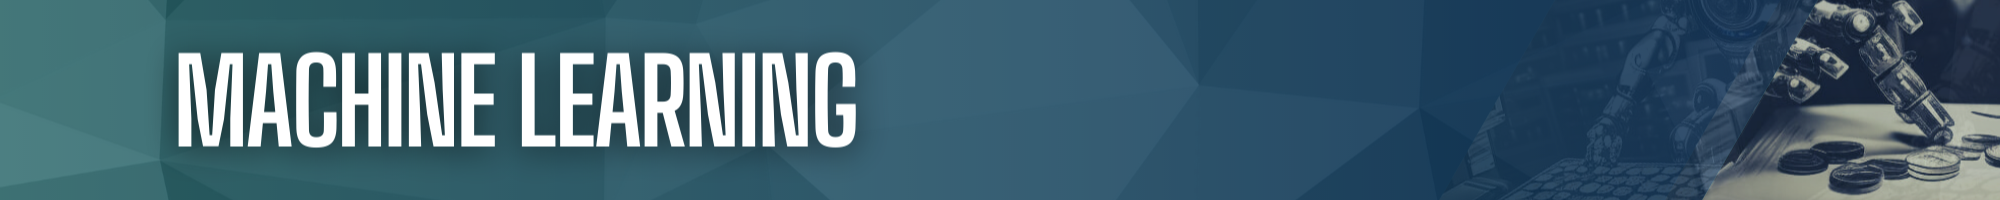

<div style="background-color: #f7f7f7; padding: 20px; border-radius: 10px; border: 2px solid #333333;">
<h2 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Gameplan</h2>
<ul style="font-family: Arial, sans-serif; color: #555555;">
<li><strong>Feature Selection:</strong> Relevant features are selected using mutual information, which measures the dependence between features and the target variable.</li>
<li><strong>Model Selection:</strong> Several regression models, including Linear Regression, Decision Tree, Random Forest, and Support Vector Machine, are considered for predicting coin rarity.</li>
<li><strong>Hyperparameter Tuning:</strong> The models are fine-tuned using grid search and cross-validation to find the optimal combination of hyperparameters for improved performance.</li>
<li><strong>Ensemble Learning:</strong> An ensemble model is created using the voting regressor technique, which combines the predictions of multiple models to enhance prediction accuracy.</li>
<li><strong>Model Evaluation:</strong> The performance of each individual model and the ensemble model is evaluated using metrics such as mean squared error, mean absolute error, and R-squared score.</li>
</ul>
<h2 style="font-family: Arial, sans-serif; color: #333333; text-align: center;">Goal</h2>
<p style="font-family: Arial, sans-serif; color: #555555;">The ultimate goal of this project is to develop a highly accurate model for predicting coin rarity.<br>Through rigorous data preprocessing, feature selection, model selection, hyperparameter tuning, and ensemble learning.<br>The performance of the models and the ensemble model will be thoroughly evaluated to assess their effectiveness in achieving this objective.</p>
</div>

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import time

In [53]:
# Load the dataset
file_path = os.path.join(os.getcwd(), 'Data', 'df_ready.csv')
df = pd.read_csv(file_path)

In [54]:
start_time = time.time()

# Handle missing values
imputer = SimpleImputer(strategy='mean')
df_imputed = imputer.fit_transform(df)

# Split the data into features (X) and target variable (y)
X = df_imputed[:, 1:]  # Exclude the target variable
y = df_imputed[:, 0]  # Target variable 'Rarity'

# Scale the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Select the best features based on mutual information
selector = SelectKBest(mutual_info_regression, k=22)
selector.fit(X_scaled, y)

selected_indices = selector.get_support(indices=True)
selected_features = df.columns[1:][selected_indices].tolist()
print("Selected Features:", selected_features)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_scaled[:, selected_indices])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Model Selection
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
random_forest = RandomForestRegressor()
svm = SVR()

models = [
    ("Linear Regression", linear_regression),
    ("Decision Tree", decision_tree),
    ("Random Forest", random_forest),
    ("Support Vector Machine", svm)
]

hyperparameters = {
    "Linear Regression": {"normalize": [True, False]},
    "Decision Tree": {"max_depth": [None, 5, 10]},
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 5, 10]},
    "Support Vector Machine": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
}

# Model Training and Hyperparameter Tuning
best_accuracy = -1
best_model = None
best_predictions = None
max_iterations = 10

print("Training models...")
for iteration in range(max_iterations):
    # Iterate over models
    for model_name, model in models:
        # Retrieve hyperparameters for the current model
        model_hyperparameters = hyperparameters[model_name]

        # Iterate over hyperparameter combinations
        for params in ParameterGrid(model_hyperparameters):
            # Set the current hyperparameters
            model.set_params(**params)

            # Retrain the model
            model_start_time = time.time()
            model.fit(X_train, y_train)
            model_elapsed_time = time.time() - model_start_time
            print(f"Iteration {iteration+1}/{max_iterations} - Trained {model_name} in {model_elapsed_time:.2f} seconds")

            # Evaluate the model
            predictions = model.predict(X_test)
            r2 = r2_score(y_test, predictions)

            # Check if the accuracy has improved
            if r2 > best_accuracy:
                best_accuracy = r2
                best_model = model_name
                best_predictions = predictions

    # Break the loop if no improvement in accuracy
    if best_model is not None and iteration > 0 and best_model == models[0][0]:
        break

# Create an ensemble of models
ensemble_models = [
    ("Linear Regression", linear_regression),
    ("Decision Tree", decision_tree),
    ("Random Forest", random_forest),
    ("Support Vector Machine", svm)
]

# Create the voting regressor
voting_regressor = VotingRegressor(estimators=ensemble_models)

# Fit the voting regressor to the training data
voting_start_time = time.time()
voting_regressor.fit(X_train, y_train)
voting_elapsed_time = time.time() - voting_start_time
print(f"Trained Voting Regressor in {voting_elapsed_time:.2f} seconds")

# Make predictions using the voting regressor
ensemble_predictions = voting_regressor.predict(X_test)

# Model Evaluation
print("Selected Features:", selected_features)
print("\nModel Evaluation:")
for model_name, model in models:
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Evaluate the ensemble model
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_mae = mean_absolute_error(y_test, ensemble_predictions)
ensemble_r2 = r2_score(y_test, ensemble_predictions)

print("\nEnsemble Model:")
print(f"MSE: {ensemble_mse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R2 Score: {ensemble_r2:.4f}")

# Print the overall best accuracy
print("\nOverall Best Prediction Accuracy:", best_accuracy)

# Print total elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)
print(f"\nTotal Elapsed Time: {hours:02d}:{minutes:02d}:{seconds:02d}")


Selected Features: ['Mintage', 'Engraver', 'Times Issued', 'Currency', 'Diameter', 'Issuer', 'Weight', 'Year', 'Year_Missing', 'Mintage_Missing', 'Edge_Special', 'Composition_Bimetallic', 'Composition_Gold', 'Composition_Silver', 'Demonetized_-1', 'Orientation_unknown', 'Type_Circulating commemorative coin', 'Type_Non-circulating coin', 'Type_Standard circulation coin', 'Type_Token/Medal', 'Technique_Milled', 'Technique_Other']
Training models...
Iteration 1/10 - Trained Linear Regression in 0.01 seconds
Iteration 1/10 - Trained Linear Regression in 0.01 seconds
Iteration 1/10 - Trained Decision Tree in 0.09 seconds
Iteration 1/10 - Trained Decision Tree in 0.03 seconds
Iteration 1/10 - Trained Decision Tree in 0.05 seconds
Iteration 1/10 - Trained Random Forest in 5.77 seconds
Iteration 1/10 - Trained Random Forest in 11.83 seconds
Iteration 1/10 - Trained Random Forest in 17.43 seconds
Iteration 1/10 - Trained Random Forest in 1.93 seconds
Iteration 1/10 - Trained Random Forest in 4.

Iteration 7/10 - Trained Support Vector Machine in 9.52 seconds
Iteration 7/10 - Trained Support Vector Machine in 4.07 seconds
Iteration 7/10 - Trained Support Vector Machine in 46.78 seconds
Iteration 7/10 - Trained Support Vector Machine in 4.73 seconds
Iteration 7/10 - Trained Support Vector Machine in 324.22 seconds
Iteration 7/10 - Trained Support Vector Machine in 10.15 seconds
Iteration 8/10 - Trained Linear Regression in 0.00 seconds
Iteration 8/10 - Trained Linear Regression in 0.00 seconds
Iteration 8/10 - Trained Decision Tree in 0.09 seconds
Iteration 8/10 - Trained Decision Tree in 0.03 seconds
Iteration 8/10 - Trained Decision Tree in 0.05 seconds
Iteration 8/10 - Trained Random Forest in 5.59 seconds
Iteration 8/10 - Trained Random Forest in 11.31 seconds
Iteration 8/10 - Trained Random Forest in 16.94 seconds
Iteration 8/10 - Trained Random Forest in 1.80 seconds
Iteration 8/10 - Trained Random Forest in 3.70 seconds
Iteration 8/10 - Trained Random Forest in 5.37 secon